# Chapter 6 - Model evaluation and Hyperparameter tuning

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header = None)

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y) #Transform old classes of dataset represented as characters to 0 and 1
le.classes_ #old classes

array(['B', 'M'], dtype=object)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 1)

### Pipeline class
Pipeline takes an arbitrary number of scikit-learn transformers, followed by an estimator that implements the fit and predict methods. Can be seen as a wrapper

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components = 2),
                       LogisticRegression(random_state = 1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


## Crossvalidation
Two common methods to help find an acceptable bias-variance trade-off: Holdout cross-validation and k-fold cross-validation

### Holdout cross-validation
split the initial dataset into training, validation and test-set. Use the validation set to change hyperparameters and tune the model. Use the test-set only for ultimate performance estimation.
Often the test-set is used as validation set: This is not a good machine-learning practice

The holdout method is very sensitive to how the trainign set is partitioned into training and validation set. K-fold cross-validation is therefore more robust

## K-fold cross-validation
In K-fold cross-validation the training dataset is split into k-folds without replacement, where k-1 folds are used for the model training, and one fold is used for performance evaluation. This procedure is repeated k-times so that we obtain k models and performance estimates. 
Aftwerwards the average performance of the models is estimated so that it is less sensitive to the sub-partitioning of the holdout method.

A good standard for k in k-fold cross-validation is 10. If working with smaller datasets, increasing the number of k may be useful. Working with large datasets a larger value of k may be suficient while reducing the computational cost.

In stratified k-fold cross-validation the class proportions are preserved in each fold and often yield better performance.

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits = 10,
                       random_state = 1).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [10]:
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV accuracy: 0.950 +/- 0.014


In [11]:
#Easy to implment via cross_val_score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = pipe_lr,
                        X = X_train,
                        y = y_train,
                        cv = 10, 
                        n_jobs = 1)

print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


### Debugging alrogirthms with learning and validation curves

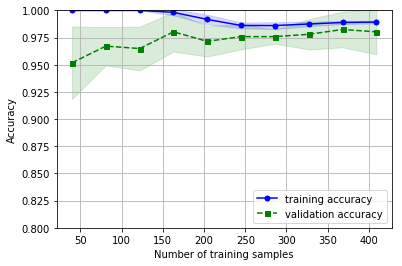

In [19]:
#Via learning curve function of scikit-learn
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty = 'l2',
                                         random_state = 1))
train_sizes, train_scores, test_scores = learning_curve(estimator = pipe_lr,
                                                       X = X_train,
                                                       y = y_train,
                                                       train_sizes = np.linspace(0.1, 1.0, 10),
                                                       cv = 10,
                                                       n_jobs = 1)

train_mean = np.mean(train_scores, axis =1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis =1)
test_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'training accuracy')

plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')

plt.plot(train_sizes, test_mean, color = 'green', linestyle='--', marker = 's', markersize = 5, label = 'validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.00])
plt.show()

## Learning curves vs. validation curves
In the above plots we plotted the training and test accruacies as functions of the sample size (=learning curve). In validation curves we vary the values of the model parameters (for example the inverse regularization parameter C in LR).

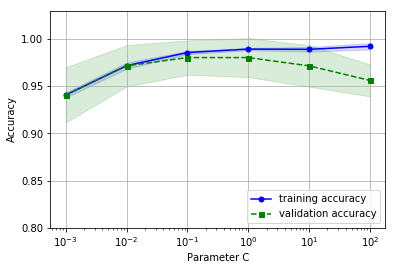

In [23]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator = pipe_lr,
                                            X = X_train,
                                            y = y_train,
                                            param_name = 'logisticregression__C',
                                            param_range = param_range,
                                            cv = 10)
train_mean = np.mean(train_scores, axis =1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis =1)
test_std = np.std(test_scores, axis = 1)

plt.plot(param_range, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'training accuracy')

plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')

plt.plot(param_range, test_mean, color = 'green', linestyle='--', marker = 's', markersize = 5, label = 'validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = 'green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.03])
plt.show()

## Hyperparamter tuning via grid search

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state = 1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C' : param_range,
               'svc__kernel' : ['linear']},
              {'svc__C' : param_range,
              'svc__gamma' : param_range,
              'svc__kernel' : ['rbf']}]
gs = GridSearchCV(estimator = pipe_svc,
                 param_grid = param_grid,
                 scoring = 'accuracy',
                 cv = 10,
                 n_jobs = -1)
#GRid search is computationally very expensive, RandomzedSearchCV is less expensive and makes random combinations

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [29]:
#Set best estimators of grid search to classifier (clf) and fit it to the training set.
clf = gs.best_estimator_
clf.fit(X_test, y_test)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.991


Nested cross-validation an outer k-fold cross-validations loop to split the data into trainign and test folds, and an inner loop to select the model using k-fold cross-validation on the training fold.

In [32]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid = param_grid,
                 scoring = 'accuracy',
                 cv = 2) #CV describes the inner loop (2)
scores = cross_val_score(gs,X_train, y_train, scoring = 'accuracy', cv = 5) #CV describes the outer loop (5)

#Combined a 5x2 cross-validation

print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))

CV accuracy: 0.974 +/- 0.015


In [34]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state =0),
                 param_grid = [{'max_depth' : [1, 2, 3, 4, 5, 6, 7, None]}],
                 scoring = 'accuracy',
                 cv = 2)
scores = cross_val_score(gs,X_train, y_train, scoring = 'accuracy', cv = 5)

print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy: 0.934 +/- 0.016


Using nested cross-validation we compared SVM with decision tree classifier; SVM performes notably better and thus we expect that it is the better choice to classify new data that comes from the same population as this dataset.

## Performance evaluation metrics

In [35]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


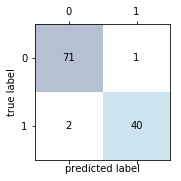

In [41]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i,j], va = 'center', ha = 'center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

## Error metrics
* Accuracy = (True positives + True negatives) / Total number of predictions
* Error = (False positives + False negatieves) / Total number of predictions = 1-accuracy


* True positive rate = TPR = True positives / (False negatives + True positives) = Sensitivity
* False positive rate = FPR = False positives / (False positives + True negatives) = 1 - Specificity


* Precision = True positives / (True positives + false positives) = Positive predicive value
* Recall = True positives / (False negatives + True positives) = TPR = Sensitivity


* F1-score = 2((Precision * Recall)/(Precision + Recall))

In [42]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true = y_test, y_pred = y_pred))
print('Recall: %.3f' % recall_score(y_true = y_test, y_pred = y_pred))
print('F1: %.3f' % f1_score(y_true = y_test, y_pred = y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [43]:
#A different scoring metric can be used in the GridSearchCV, for example f1-score.
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label= 0) #Make own scorer

gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, scoring = scorer, cv = 10)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9880219137963148
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


## Ploting a ROC-curve

ROC-curves are useful for selecting models based on their performance with respect to TPR (sensitivity) and FPR (1-specificity)
A perfect classifier will be toplift with a TPR of 1 and FPR of 0. We can also plot a precision-recall curve.

Below a ROC curve that onlyu uses two features.

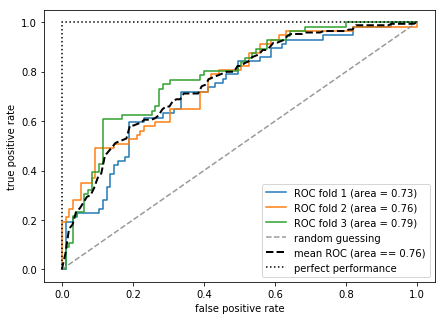

In [47]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components = 2),
                       LogisticRegression(penalty = 'l2',
                       random_state = 1, C = 100.0))

X_train2 = X_train[:, [4,14]]
cv = list(StratifiedKFold(n_splits = 3, random_state=1).split(X_train, y_train))

fig = plt.figure(figsize = (7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []

for i, (train,test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                        y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                    probas[:,1],
                                    pos_label = 1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    
plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
        label = 'mean ROC (area == %0.2f)' % mean_auc, lw = 2)
plt.plot([0,0,1], [0,1,1], linestyle = ':', color = 'black', label = 'perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc = 'lower right')
plt.show()

## Scoring metrics for multiclass classification
Micro-averaging is useful if we want tow eigh each instance or prediction equally (Precision-micro = (TP1 + TP2 .... TPk) / TP1 + TP2 + ... TPk + FP1 + .... FPk)
Macro-avering is able to equally evaluate the overall performance of a classifier with regard to most frequent class labels. (precision macro = (Precision1 + .... Precisionk / k))

In [57]:
pre_scorer = make_scorer(score_func = precision_score,
                        pos_label = 1,
                        greater_is_better = True,
                        average = 'micro')

## Dealing with class imbalance

In [59]:
#Create imbalanced dataset
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

In [60]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

Accuracy of prediction with only zeroes is 90%.

One way to deal with imbalanced class proportions during model fitting is to assign a larger penalty to wrong predictions on the minority class. Other popular methods are upsampling the minority class, downsampling the majority class and generation of synthetic training samples.

Example with resample --> is an upsample technique that upsamples the iminority class by drawing new samples from the dataset with replacement.

In [61]:
from sklearn.utils import resample

print('Number of class 1 samples before:', X_imb[y_imb == 1].shape[0])

Number of class 1 samples before: 40


In [63]:
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1], y_imb[y_imb == 1],
                                   replace = True,
                                   n_samples= X_imb[y_imb ==0].shape[0],
                                   random_state = 123)
print('Number of class 1 samples after:', X_upsampled.shape[0])

Number of class 1 samples after: 357


In [64]:
#Creating the balanced dataset
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))

In [65]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0